# Telcom Customer Churn
Matthew Mandel Hemsley

### Remember:  Churn in this dataset represents individuals who left within the last month

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Data Read In
churn_df = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv') # .CSV provided by Kaggle: https://www.kaggle.com/blastchar/telco-customer-churn

In [3]:
churn_df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Reindexing onto Customer ID as it is our unique key for this dataset

In [5]:
#Check Customer ID for duplicates
if churn_df['customerID'].duplicated().sum() == 0:
    print('Duplicate Check before Reindexing:',churn_df['customerID'].duplicated().sum())
    #Set Index as CustomerID
    churn_df.set_index('customerID', inplace=True) 
else:
    print('Please Check Dataset. Duplicates Found.')
    print('Duplicates: ',churn_df['customerID'].duplicated())

Duplicate Check before Reindexing: 0


As we know our focus will be on Churn, let's take a look at it now to see what we will be using to construct our model.

In [6]:
#Churn Column Analysis
churned_not,churned = churn_df['Churn'].value_counts()
print(f'Number of Customers Retained: {churned_not}')
print(f'Number of Customers Churned: {churned}')
print(f'Percentage of Customers Lost: {round(churned/(churned+churned_not),3)*100}%')


Number of Customers Retained: 5174
Number of Customers Churned: 1869
Percentage of Customers Lost: 26.5%


From this, we can see that we are going to be dealing with imbalanced classes. Due to the size of the dataset, as well as the ratio of the imbalance, we can temporarily ignore this imbalance, though it may be a cause of prediction issues when we get into modelling, and thus is important to make note of here.

## Data Cleaning
To begin with, we are going to go through the object columns to determine what we are keeping/binarizing/dropping

In [7]:
#Loop through all object columns and show unique values to determine binzarization
for column in churn_df:
    if churn_df[column].dtypes == 'object':
        print(f' Column Name: {column}')
        print(f' Column Unique Values: {churn_df[column].unique()}')
        print(f'')

 Column Name: gender
 Column Unique Values: ['Female' 'Male']

 Column Name: Partner
 Column Unique Values: ['Yes' 'No']

 Column Name: Dependents
 Column Unique Values: ['No' 'Yes']

 Column Name: PhoneService
 Column Unique Values: ['No' 'Yes']

 Column Name: MultipleLines
 Column Unique Values: ['No phone service' 'No' 'Yes']

 Column Name: InternetService
 Column Unique Values: ['DSL' 'Fiber optic' 'No']

 Column Name: OnlineSecurity
 Column Unique Values: ['No' 'Yes' 'No internet service']

 Column Name: OnlineBackup
 Column Unique Values: ['Yes' 'No' 'No internet service']

 Column Name: DeviceProtection
 Column Unique Values: ['No' 'Yes' 'No internet service']

 Column Name: TechSupport
 Column Unique Values: ['No' 'Yes' 'No internet service']

 Column Name: StreamingTV
 Column Unique Values: ['No' 'Yes' 'No internet service']

 Column Name: StreamingMovies
 Column Unique Values: ['No' 'Yes' 'No internet service']

 Column Name: Contract
 Column Unique Values: ['Month-to-month' 

TotalCharges should not be an object, so that will be the first thing we examine

In [8]:
for value in churn_df['TotalCharges']:
        if len(value) == 1:
            print(f'Problem Value:{value}')

Problem Value: 
Problem Value: 
Problem Value: 
Problem Value: 
Problem Value: 
Problem Value: 
Problem Value: 
Problem Value: 
Problem Value: 
Problem Value: 
Problem Value: 


Though difficult to see, our issue in this column is the several ' ' values in cells

In [9]:
#Replacing spaces with np.NaN and casting the column as a float
churn_df['TotalCharges'] = churn_df['TotalCharges'].replace(' ',np.NaN)
churn_df['TotalCharges'] = churn_df['TotalCharges'].astype(float)

Several columns, including Churn, consist of Yes/No strings which we can quickly convert into 1/0

In [10]:
#List of columns to binarize
binarize_list = ['Partner','Dependents','PhoneService','PaperlessBilling','Churn']

#Loop through each column in the binarize_list and binarize
for column in churn_df[binarize_list]:
        churn_df[column] = churn_df[column].map({'Yes':1,'No':0})

Several columns consist of No internet service values, in addition to Yes and No. These columns will be binarized, with np.nulls filling the No internet service values for cleaning purposes.

These may be dropped later depending on the quanity.

In [11]:
#List of columns to alter
np_list = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

#Loop through each column in the np_list and alter values accounting to .map parameters
for column in churn_df[np_list]:
    churn_df[column] = churn_df[column].map({'Yes':2,'No':1,'No internet service':0})

In [12]:
churn_df['gender'] = churn_df['gender'].map({'Female':1,'Male':0}) #Binarize Gender

In [13]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null 

In [14]:
for column in churn_df:
    if churn_df[column].dtypes == 'object':
        print(f' Column Name: {column}')
        print(f' Column Unique Values: {churn_df[column].unique()}')
        print(f'')

 Column Name: MultipleLines
 Column Unique Values: ['No phone service' 'No' 'Yes']

 Column Name: InternetService
 Column Unique Values: ['DSL' 'Fiber optic' 'No']

 Column Name: Contract
 Column Unique Values: ['Month-to-month' 'One year' 'Two year']

 Column Name: PaymentMethod
 Column Unique Values: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']



In [15]:
dummies_list = ['MultipleLines','InternetService','Contract','PaymentMethod']

churn_df = pd.get_dummies(churn_df,columns=dummies_list)

I believe PaymentMethod can be turned into a simpler category of Automatic vs Manual. To determine whether this is worth doing, I'm going to first turn PaymentMethod into a numeric categories

In [16]:
#PaymentMethodType will be add with Automatic vs Manual, with Automatic being 1 and Manual being 0, using PaymentMethod's values
#churn_df['PaymentMethodType'] = churn_df['PaymentMethod'].map({'Electronic check':0,'Mailed check':0,'Bank transfer (automatic)':1,'Credit card (automatic)':1})

In [17]:
#Clear all NaNs
churn_df.dropna(inplace=True)

Exporting cleaned data set

In [18]:
churn_df.to_csv('./data/clean_churn.csv')

### Visualizations

In [32]:
for column in churn_df:
    print(column,'Class Balance:',round(churn_df[column].mean(),4))
    print('')

gender Class Balance: 0.4953

SeniorCitizen Class Balance: 0.1624

Partner Class Balance: 0.4825

Dependents Class Balance: 0.2985

tenure Class Balance: 32.4218

PhoneService Class Balance: 0.9033

OnlineSecurity Class Balance: 1.0704

OnlineBackup Class Balance: 1.1287

DeviceProtection Class Balance: 1.1277

TechSupport Class Balance: 1.0739

StreamingTV Class Balance: 1.1682

StreamingMovies Class Balance: 1.1722

PaperlessBilling Class Balance: 0.5927

MonthlyCharges Class Balance: 64.7982

TotalCharges Class Balance: 2283.3004

Churn Class Balance: 0.2658

MultipleLines_No Class Balance: 0.4814

MultipleLines_No phone service Class Balance: 0.0967

MultipleLines_Yes Class Balance: 0.4219

InternetService_DSL Class Balance: 0.3436

InternetService_Fiber optic Class Balance: 0.4403

InternetService_No Class Balance: 0.2162

Contract_Month-to-month Class Balance: 0.5511

Contract_One year Class Balance: 0.2093

Contract_Two year Class Balance: 0.2396

PaymentMethod_Bank transfer (au

We can already make some conclusions based off the above table. We have slightly more males in our sample, and only 16% of our sample consists of individuals over 65 years of age. Since we care about Churn, lets take a look specifically at that.

In [20]:
print('Our Churn Rate:',round(churn_df['Churn'].mean(),4))

Our Churn Rate: 0.2658


Seeing that 26.58% of the customers in this dataset have churned, next we will create a heatmap correlated around Churn to see what is impactful and by how much.

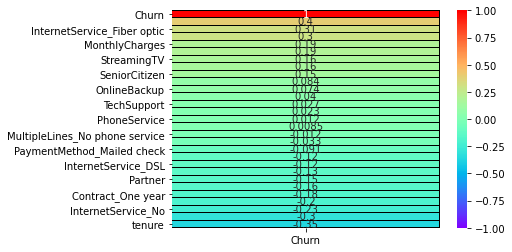

In [21]:
sns.heatmap(churn_df.corr()[['Churn']].sort_values(by='Churn', ascending=False),
           annot=True,
           cmap='rainbow',
            vmin=-1, vmax=1,
           linewidths=0.05,linecolor='black',
           );

InternetService, Contract, and Tenure seem to be the most impactful currently. Let's explore those columns.

In [22]:
list_contract_breaker = ['Churn','Contract_One year','Contract_Two year','Contract_Month-to-month','tenure']

In [23]:
for column in churn_df[list_contract_breaker]:
    print('')
    print(column)
    print(churn_df[column].groupby(by=churn_df['Churn']).describe())
    print('')


Churn
        count  mean  std  min  25%  50%  75%  max
Churn                                            
0      5163.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1      1869.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0


Contract_One year
        count      mean       std  min  25%  50%  75%  max
Churn                                                     
0      5163.0  0.252954  0.434747  0.0  0.0  0.0  1.0  1.0
1      1869.0  0.088818  0.284556  0.0  0.0  0.0  0.0  1.0


Contract_Two year
        count      mean       std  min  25%  50%  75%  max
Churn                                                     
0      5163.0  0.317064  0.465378  0.0  0.0  0.0  1.0  1.0
1      1869.0  0.025682  0.158228  0.0  0.0  0.0  0.0  1.0


Contract_Month-to-month
        count      mean       std  min  25%  50%  75%  max
Churn                                                     
0      5163.0  0.429983  0.495121  0.0  0.0  0.0  1.0  1.0
1      1869.0  0.885500  0.318502  0.0  1.0  1.0  1.0  1.0


tenure
        co

We can see that out of the contract types, Month-to-Month is a far more important indicator for likelyhood of churning. Let's explore tenure a bit more to see if there are any clear trends.

Tenure Descriptive Statistical Measurements
count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


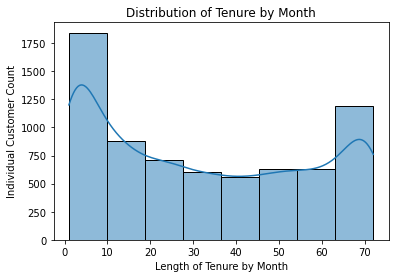

In [24]:
print('Tenure Descriptive Statistical Measurements')
print(churn_df['tenure'].describe())

#Plot distribution of tenure
plt.title('Distribution of Tenure by Month')
plt.xlabel('Length of Tenure by Month')
plt.ylabel('Individual Customer Count')
sns.histplot(data=churn_df['tenure'],kde=True,bins=int(np.sqrt(72)));

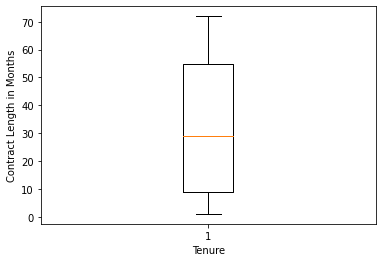

In [25]:
#Boxplot of Tenure
plt.xlabel(xlabel='Tenure')
plt.ylabel('Contract Length in Months')
plt.boxplot(x=churn_df['tenure']);

Let's isolate the churned customers and place them in their own database.

In [26]:
#Creating a seperate dataframe of all churned customers for this month, with number of months they were on contract
tenure_churned_df = pd.DataFrame(churn_df['tenure'].where(churn_df['Churn']==True))

#Dropping null values to isolate all churned customers, as all null values are for retained customers for this specific dataframe
tenure_churned_df.dropna(inplace=True)
tenure_churned_df.describe()

,tenure
count,1869.000000
mean,17.979133
std,19.531123
min,1.000000
25%,2.000000
50%,10.000000
75%,29.000000
max,72.000000


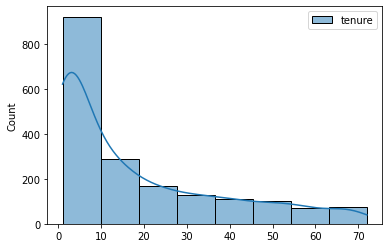

In [27]:
#Creating a histogram to examine the distribution of the data for trends and patterns
sns.histplot(data=tenure_churned_df, kde=True,bins=int(np.sqrt(72)));

We can see that the bulk of our churned customers were within the first 10 months of their subscription, with a gradual but steady decrease in the first 30 months. Let's examine what the culmative monthly churn probability, based on these numbers.

In [28]:
#Look at the culmative churn probability 
for i in [1,2,3,6,12,18,24]: #Looks at 1/2/3/6/12/24 month churn probability respectively
    print('The probability of a Month-to-Month customer churning within',
          i,'months is: ', "{:.0%}".format(tenure_churned_df.value_counts(normalize=True)[0:i].sum()))
    
    if i == 12:
        print('Compared to a One Year Length customer:',"{:.0%}".format(churn_df['Contract_One year'].mean()))

    elif i == 24:
        print('Compared to a Two Year Length Customer:',"{:.0%}".format(churn_df['Contract_Two year'].mean()))
    print('')

The probability of a Month-to-Month customer churning within 1 months is:  20%

The probability of a Month-to-Month customer churning within 2 months is:  27%

The probability of a Month-to-Month customer churning within 3 months is:  32%

The probability of a Month-to-Month customer churning within 6 months is:  43%

The probability of a Month-to-Month customer churning within 12 months is:  56%
Compared to a One Year Length customer: 21%

The probability of a Month-to-Month customer churning within 18 months is:  65%

The probability of a Month-to-Month customer churning within 24 months is:  72%
Compared to a Two Year Length Customer: 24%



As we would expect, locking customers into contracts drastically reduces the chances of them churning. We can see that most customers churn 56% of the time by the end of their first year, where as only 21% of contract holders churn at the end of their contracts.

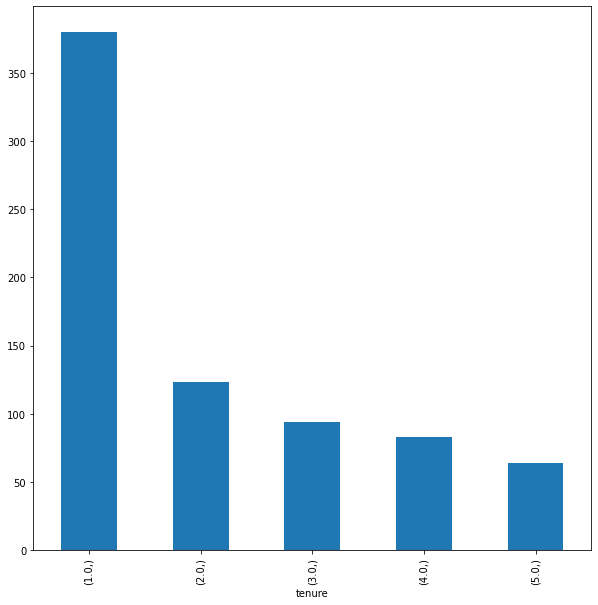

In [29]:
top_ten_tenure_months = tenure_churned_df.value_counts(normalize=False)[0:5]
labels = ['1 Month','2 Months','3 Months','4 Months','5 Months']
plt.figure(figsize=(10,10))
top_ten_tenure_months.plot(kind='bar');